# Training and validating RNN + MPL model with the WHXE loss function

## Imports

In [1]:
import time
import pickle
import platform
import os
import imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random 

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow import keras
from tqdm import tqdm

from LSTM_model import get_LSTM_Classifier
from dataloader import LSSTSourceDataSet, load, get_augmented_data, get_static_features, ts_length
from loss import WHXE_Loss
from taxonomy import get_taxonomy_tree, get_prediction_probs, get_highest_prob_path, plot_colored_tree
from vizualizations import make_gif, plot_confusion_matrix, plot_roc_curves
from interpret_results import get_conditional_probabilites, save_all_cf_and_rocs, save_leaf_cf_and_rocs

2024-06-17 07:18:18.592747: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-17 07:18:20.032842: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 07:18:20.034830: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 07:18:20.233614: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-17 07:18:20.611303: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print("Tensorflow version", tf.__version__)
print("Python version", platform.python_version())

Tensorflow version 2.15.0
Python version 3.10.12


In [3]:
seed = 42
random.seed(seed)

## Load and balance the tensors:

This step takes a while because it has load from disc to memory...

In [4]:
X_ts = load("processed/train/x_ts.pkl")
X_static = load("processed/train/x_static.pkl")
Y = load("processed/train/y.pkl")
astrophysical_classes = load("processed/train/a_labels.pkl")

In [5]:
a, b = np.unique(astrophysical_classes, return_counts=True)
print(f"Total sample count = {np.sum(b)}")
pd.DataFrame(data = {'Class': a, 'Count': b})

Total sample count = 1081614


,Class,Count
0,AGN,76258
1,CART,8207
2,Cepheid,13771
3,Delta Scuti,20650
4,Dwarf Novae,8025
5,EB,66454
6,ILOT,7461
7,KN,4426
8,M-dwarf Flare,1859
9,PISN,63586


Small step to convert X_static from a dictionary to an array

In [6]:
for i in tqdm(range(len(X_static))):        
    X_static[i] = get_static_features(X_static[i])

100%|██████████| 1081614/1081614 [00:06<00:00, 156723.09it/s]


Balance the data set in some way

In [7]:
max_class_count = 30000

X_ts_balanced = []
X_static_balanced = []
Y_balanced = []
astrophysical_classes_balanced = []

for c in np.unique(astrophysical_classes):

    idx = list(np.where(np.array(astrophysical_classes) == c)[0])
    
    if len(idx) > max_class_count:
        idx = random.sample(idx, max_class_count)
 
    X_ts_balanced += [X_ts[i] for i in idx]
    X_static_balanced += [X_static[i] for i in idx]
    Y_balanced += [Y[i] for i in idx]
    astrophysical_classes_balanced += [astrophysical_classes[i] for i in idx]

# Print summary of the data set used for training and validation
a, b = np.unique(astrophysical_classes_balanced, return_counts=True)
data_summary = pd.DataFrame(data = {'Class': a, 'Count': b})
data_summary

,Class,Count
0,AGN,20000
1,CART,8207
2,Cepheid,13771
3,Delta Scuti,20000
4,Dwarf Novae,8025
5,EB,20000
6,ILOT,7461
7,KN,4426
8,M-dwarf Flare,1859
9,PISN,20000


Free up some memory

In [8]:
del X_ts, X_static, Y, astrophysical_classes

Split into train and validation

In [9]:
val_fraction = 0.05
X_ts_train, X_ts_val, X_static_train, X_static_val, Y_train, Y_val, astrophysical_classes_train, astrophysical_classes_val = train_test_split(X_ts_balanced, X_static_balanced, Y_balanced, astrophysical_classes_balanced, shuffle=True, random_state = seed, test_size = val_fraction)

Free up some more memory

In [10]:
del X_ts_balanced, X_static_balanced, Y_balanced, astrophysical_classes_balanced

Check make up of the validation data

## Define the Loss function, criterion, etc.

In [11]:
# Loss and optimizer
tree = get_taxonomy_tree()
loss_object = WHXE_Loss(tree, astrophysical_classes_train, alpha=0) 
criterion = loss_object.compute_loss

## Train the classifier using WHXE loss and save the model

In [12]:
optimizer = keras.optimizers.Adam(learning_rate=5e-4)

2024-06-17 07:21:00.064394: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31127 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3a:00.0, compute capability: 7.0
2024-06-17 07:21:00.065826: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31127 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b3:00.0, compute capability: 7.0


In [17]:
# Inputs for model
ts_dim = 5
static_dim = len(X_static_train[0])
output_dim = 26
latent_size = 64

num_epochs = 70
batch_size = 1024

In [14]:
model = get_LSTM_Classifier(ts_dim, static_dim, output_dim, latent_size)
model.compile(optimizer=optimizer, loss=criterion)

In [15]:
keras.utils.plot_model(model, to_file='lstm.pdf', show_shapes=True, show_layer_names=True)
plt.close()

In [16]:
@tf.function
def train_step(x_ts, x_static, y):
    with tf.GradientTape() as tape:
        logits = model((x_ts, x_static), training=True)
        loss_value = criterion(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    return loss_value


Start of epoch 0:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:23<00:00, 11984.89it/s]


Training...


2024-06-17 07:22:43.538903: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_18/output/_21'
2024-06-17 07:22:44.428825: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90000
2024-06-17 07:22:45.674418: I external/local_xla/xla/service/service.cc:168] XLA service 0x14d56b6f3000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-17 07:2

Avg training loss: 1.3181
Time taken: 48.37s
Best model is at epoch 0. Saving

Start of epoch 1:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:21<00:00, 13105.06it/s]


Training...
Avg training loss: 0.8877
Time taken: 36.82s
Best model is at epoch 1. Saving

Start of epoch 2:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:20<00:00, 13561.19it/s]


Training...
Avg training loss: 0.8342
Time taken: 39.09s
Best model is at epoch 2. Saving

Start of epoch 3:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:21<00:00, 12904.82it/s]


Training...
Avg training loss: 0.7757
Time taken: 45.82s
Best model is at epoch 3. Saving

Start of epoch 4:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:20<00:00, 13362.34it/s]


Training...
Avg training loss: 0.7412
Time taken: 42.10s
Best model is at epoch 4. Saving

Start of epoch 5:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:21<00:00, 13080.92it/s]


Training...
Avg training loss: 0.9338
Time taken: 33.37s

Start of epoch 6:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:20<00:00, 13524.21it/s]


Training...
Avg training loss: 0.7920
Time taken: 37.39s

Start of epoch 7:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:21<00:00, 12986.60it/s]


Training...
Avg training loss: 0.6227
Time taken: 49.48s
Best model is at epoch 7. Saving

Start of epoch 8:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:21<00:00, 13295.48it/s]


Training...
Avg training loss: 0.6270
Time taken: 42.77s

Start of epoch 9:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:21<00:00, 13272.58it/s]


Training...
Avg training loss: 0.5740


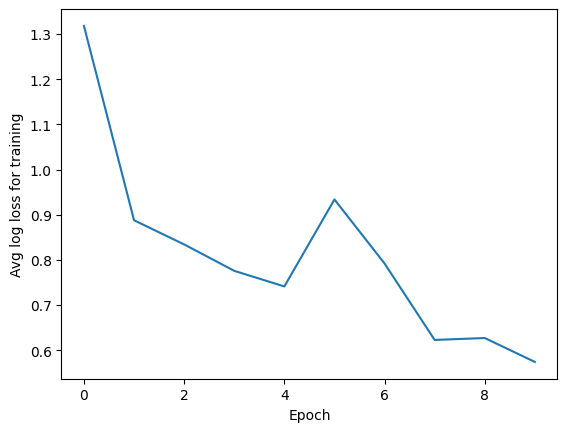

Time taken: 44.82s
Best model is at epoch 9. Saving

Start of epoch 10:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:21<00:00, 13267.66it/s]


Training...
Avg training loss: 0.6624
Time taken: 38.82s

Start of epoch 11:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:20<00:00, 13418.56it/s]


Training...
Avg training loss: 0.5212
Time taken: 46.60s
Best model is at epoch 11. Saving

Start of epoch 12:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:20<00:00, 13409.33it/s]


Training...
Avg training loss: 0.5064
Time taken: 45.47s
Best model is at epoch 12. Saving

Start of epoch 13:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:21<00:00, 13336.17it/s]


Training...
Avg training loss: 0.5142
Time taken: 43.24s

Start of epoch 14:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:20<00:00, 13530.18it/s]


Training...
Avg training loss: 0.6937
Time taken: 35.87s

Start of epoch 15:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:21<00:00, 13237.95it/s]


Training...
Avg training loss: 0.5629
Time taken: 39.93s

Start of epoch 16:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:20<00:00, 13480.87it/s]


Training...
Avg training loss: 0.4803
Time taken: 44.06s
Best model is at epoch 16. Saving

Start of epoch 17:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:21<00:00, 13075.87it/s]


Training...
Avg training loss: 0.4569
Time taken: 45.23s
Best model is at epoch 17. Saving

Start of epoch 18:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:20<00:00, 13531.26it/s]


Training...
Avg training loss: 0.4641
Time taken: 43.71s

Start of epoch 19:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:21<00:00, 13180.36it/s]


Training...
Avg training loss: 0.4488


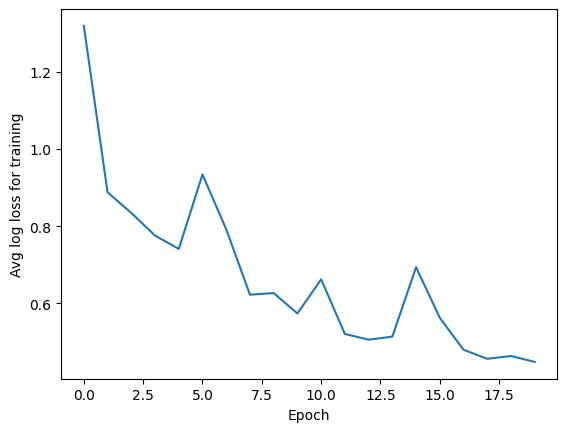

Time taken: 44.47s
Best model is at epoch 19. Saving

Start of epoch 20:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:20<00:00, 13585.96it/s]


Training...
Avg training loss: 0.6488
Time taken: 36.06s

Start of epoch 21:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:21<00:00, 13172.73it/s]


Training...
Avg training loss: 0.4126
Time taken: 48.08s
Best model is at epoch 21. Saving

Start of epoch 22:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:20<00:00, 13761.50it/s]


Training...
Avg training loss: 0.7604
Time taken: 33.54s

Start of epoch 23:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:21<00:00, 13107.20it/s]


Training...
Avg training loss: 0.5282
Time taken: 39.85s

Start of epoch 24:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:20<00:00, 13702.74it/s]


Training...
Avg training loss: 0.5986
Time taken: 36.33s

Start of epoch 25:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:21<00:00, 12946.51it/s]


Training...
Avg training loss: 0.3818
Time taken: 49.07s
Best model is at epoch 25. Saving

Start of epoch 26:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:20<00:00, 13693.04it/s]


Training...
Avg training loss: 0.4239
Time taken: 43.33s

Start of epoch 27:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:21<00:00, 12969.66it/s]


Training...
Avg training loss: 0.6511
Time taken: 36.16s

Start of epoch 28:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:20<00:00, 13710.48it/s]


Training...
Avg training loss: 0.3907
Time taken: 46.09s

Start of epoch 29:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:21<00:00, 12938.31it/s]


Training...
Avg training loss: 0.3596


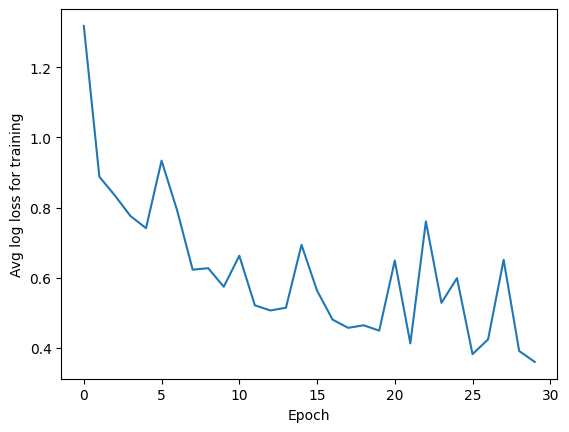

Time taken: 48.43s
Best model is at epoch 29. Saving

Start of epoch 30:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:20<00:00, 13626.29it/s]


Training...
Avg training loss: 0.4357
Time taken: 41.82s

Start of epoch 31:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:21<00:00, 12990.52it/s]


Training...
Avg training loss: 0.4359
Time taken: 42.28s

Start of epoch 32:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:20<00:00, 13602.08it/s]


Training...
Avg training loss: 0.3444
Time taken: 47.58s
Best model is at epoch 32. Saving

Start of epoch 33:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:21<00:00, 12937.74it/s]


Training...
Avg training loss: 0.5469
Time taken: 38.07s

Start of epoch 34:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:20<00:00, 13620.73it/s]


Training...
Avg training loss: 0.6819
Time taken: 34.51s

Start of epoch 35:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:21<00:00, 12966.37it/s]


Training...
Avg training loss: 0.7226
Time taken: 34.50s

Start of epoch 36:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:20<00:00, 13830.09it/s]


Training...
Avg training loss: 0.3975
Time taken: 43.76s

Start of epoch 37:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:21<00:00, 12893.36it/s]


Training...
Avg training loss: 0.3140
Time taken: 50.08s
Best model is at epoch 37. Saving

Start of epoch 38:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:20<00:00, 13649.43it/s]


Training...
Avg training loss: 0.3050
Time taken: 49.48s
Best model is at epoch 38. Saving

Start of epoch 39:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:21<00:00, 12972.94it/s]


Training...
Avg training loss: 0.6995


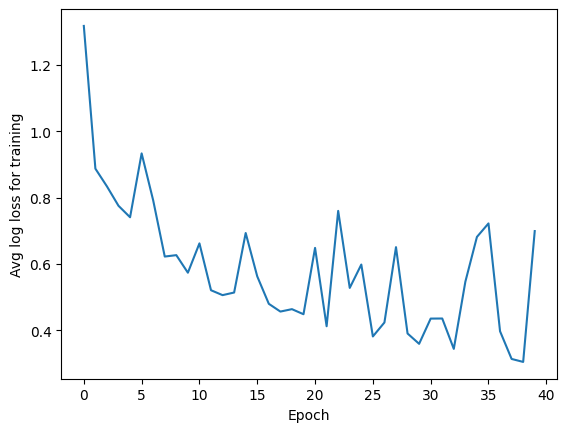

Time taken: 34.88s

Start of epoch 40:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:20<00:00, 13623.50it/s]


Training...
Avg training loss: 0.3063
Time taken: 49.23s

Start of epoch 41:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:21<00:00, 13026.98it/s]


Training...
Avg training loss: 0.4718
Time taken: 39.55s

Start of epoch 42:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:20<00:00, 13664.68it/s]


Training...
Avg training loss: 0.5507
Time taken: 36.44s

Start of epoch 43:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:21<00:00, 13084.21it/s]


Training...
Avg training loss: 0.8533
Time taken: 33.15s

Start of epoch 44:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:20<00:00, 13822.70it/s]


Training...
Avg training loss: 0.4226
Time taken: 40.42s

Start of epoch 45:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:21<00:00, 13003.03it/s]


Training...
Avg training loss: 0.4103
Time taken: 41.88s

Start of epoch 46:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:20<00:00, 13603.52it/s]


Training...
Avg training loss: 0.3112
Time taken: 47.16s

Start of epoch 47:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:21<00:00, 12849.25it/s]


Training...
Avg training loss: 0.5541
Time taken: 37.30s

Start of epoch 48:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:20<00:00, 13754.12it/s]


Training...
Avg training loss: 0.3339
Time taken: 44.86s

Start of epoch 49:
Augmenting time series lengths...


100%|██████████| 280605/280605 [00:21<00:00, 12942.50it/s]


Training...
Avg training loss: 0.4414


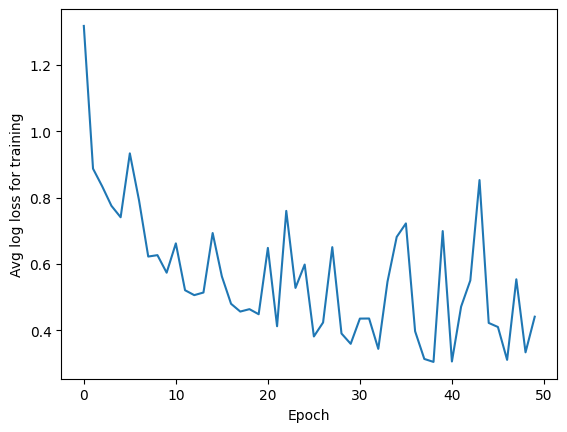

Time taken: 40.42s


In [18]:
avg_train_losses = []
for epoch in range(num_epochs):
    
    print(f"\nStart of epoch {epoch}:")
    start_time = time.time()

    print("Augmenting time series lengths...")
    
    # Create the augmented data set for training
    X_ts_train_aug, X_static_train_aug, Y_train_aug, astrophysical_classes_train_aug = get_augmented_data(X_ts_train, X_static_train, Y_train, astrophysical_classes_train)
    train_dataset =  tf.data.Dataset.from_tensor_slices((X_ts_train_aug, X_static_train_aug, Y_train_aug, astrophysical_classes_train_aug)).batch(batch_size)
    
    # Array to keep tracking of the training loss
    train_loss_values = []
    
    print("Training...")
    # Iterate over the batches of the dataset.
    for step, (x_ts_batch_train, x_static_batch_train, y_batch_train, a_class_batch_train) in enumerate(train_dataset):
        loss_value = train_step(x_ts_batch_train, x_static_batch_train, y_batch_train)
        train_loss_values.append(float(loss_value))
    
    # Log the avg train loss
    avg_train_loss = np.mean(train_loss_values)
    avg_train_losses.append(avg_train_loss)
    print(f"Avg training loss: {float(avg_train_loss):.4f}")
    
    # Plot every 10th epoch
    if (epoch + 1) % 10 == 0:
        plt.plot(list(range(len(avg_train_losses))), avg_train_losses)
        plt.xlabel("Epoch")
        plt.ylabel("Avg log loss for training")
        plt.show()

    print(f"Time taken: {time.time() - start_time:.2f}s")
    model.save(f"models/lsst_rate_agnostic/lstm_epoch_{epoch}.h5")
    
    # Save the model with the smallest training loss
    best_model_epoch = np.argmin(avg_train_losses)
    if best_model_epoch == epoch:
        print(f"Best model is at epoch {epoch} Saving")
        model.save(f"models/lsst_rate_agnostic/best_model.h5")
        
    print("==========")

## Load the saved model and validate that everthing looks okay

In [19]:
best_model = keras.models.load_model(f"models/lsst_rate_agnostic/best_model.h5", compile=False)

In [20]:
fractions = [0.1, 0.5, 1]

In [21]:
for f in fractions:

    print(f'Running inference for {int(f*100)}% light curves...')

    x1, x2, y_true, _ = get_augmented_data(X_ts_val, X_static_val, Y_val, astrophysical_classes_val, fraction=f)
    
    # Run inference on these
    y_pred = best_model.predict([x1, x2])

Running inference for 10% light curves...


100%|██████████| 14769/14769 [00:01<00:00, 12060.73it/s]


462/462 [==============================] - 3s 3ms/step
Running inference for 50% light curves...


100%|██████████| 14769/14769 [00:01<00:00, 13769.21it/s]


462/462 [==============================] - 3s 6ms/step
Running inference for 100% light curves...


100%|██████████| 14769/14769 [00:01<00:00, 14325.29it/s]


462/462 [==============================] - 4s 9ms/step


For the love of everthing that is good in this world, please use a different notebook for testing and genearting statistics. Keep this notebook simple enought to be converted into a script. 